In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.simplefilter('ignore', np.RankWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37809 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_hourly.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont_hourly','025deg_jra55_ryf_nostress_hourly','025deg_jra55_ryf_nostress_naive']

We added three diagnostics to the MoM5 code to figure out the bug in the code - (i) Resolved velocity shear, (ii) Unresolved velocity shear, and (iii) Surface buoyancy flux. We consider each of these three profiles individually.

## 1. Plotting Vtsq (Unresolved velocity shear)

In [4]:
Vtsq_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'Vtsq_array', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))
Vtsq_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'Vtsq_array', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))
Vtsq_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'Vtsq_array', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))

Text(0.5, 1.0, 'Unrsesolved velocity shear profile for latitude = -70 and longitude = 40')

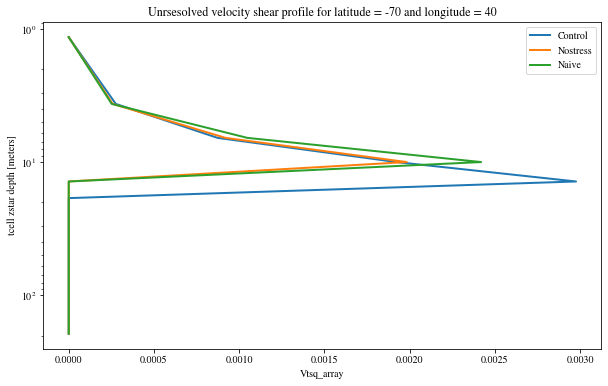

In [5]:
x_val = -70
y_val = 40
plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
Vtsq_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Control',y = 'st_ocean')
Vtsq_buo.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Nostress',y = 'st_ocean')
Vtsq_naive.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Naive',y = 'st_ocean')
plt.legend()
plt.title('Unrsesolved velocity shear profile for latitude = ' + str(x_val) + ' and longitude = ' + str(y_val))

Text(0.5, 1.0, 'Unrsesolved velocity shear profile for latitude = -180 and longitude = 30')

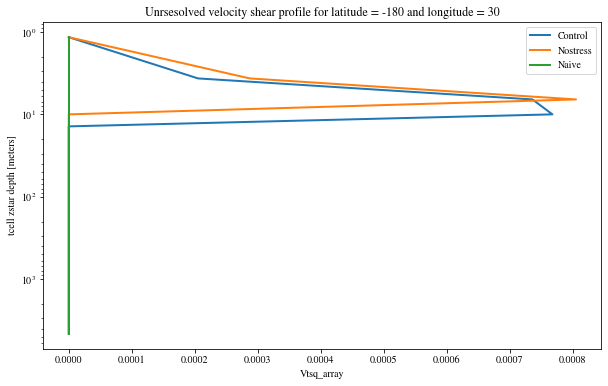

In [6]:
x_val = -180
y_val = 30
plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
Vtsq_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Control',y = 'st_ocean')
Vtsq_buo.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Nostress',y = 'st_ocean')
Vtsq_naive.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Naive',y = 'st_ocean')
plt.legend()
plt.title('Unrsesolved velocity shear profile for latitude = ' + str(x_val) + ' and longitude = ' + str(y_val))

The unresolved velocity shear does show differences, but not so much(except at a few locations).

## 1.1 Doing an averaging over North Atlantic and Pacific ocean

In [8]:
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1)

area_t_NA = area_t.sel(xt_ocean = slice(-90,10)).sel(yt_ocean = slice(10,65))

Vtsq_avg_con = (Vtsq_con*area_t_NA).sum(dim = ['yt_ocean','xt_ocean'])/area_t_NA.sum(dim = ['yt_ocean','xt_ocean'])
Vtsq_avg_buo = (Vtsq_buo*area_t_NA).sum(dim = ['yt_ocean','xt_ocean'])/area_t_NA.sum(dim = ['yt_ocean','xt_ocean'])
Vtsq_avg_naive = (Vtsq_naive*area_t_NA).sum(dim = ['yt_ocean','xt_ocean'])/area_t_NA.sum(dim = ['yt_ocean','xt_ocean'])

Text(0.5, 1.0, 'Averaging resolved velocity shear over North Atlantic')

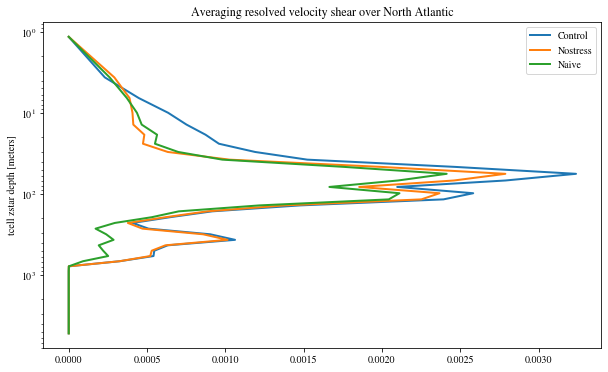

In [15]:
plt.figure(figsize = (10,6))

plt.yscale('log')
plt.gca().invert_yaxis()

Vtsq_avg_con.plot(label = 'Control',y = 'st_ocean')
Vtsq_avg_buo.plot(label = 'Nostress',y = 'st_ocean')
Vtsq_avg_naive.plot(label = 'Naive',y = 'st_ocean')
plt.legend()
plt.title('Averaging unresolved velocity shear over North Atlantic')

In [16]:
area_t_NP = area_t.sel(xt_ocean = slice(-250,-100)).sel(yt_ocean = slice(10,65))

Vtsq_avg_con = (Vtsq_con*area_t_NP).sum(dim = ['yt_ocean','xt_ocean'])/area_t_NP.sum(dim = ['yt_ocean','xt_ocean'])
Vtsq_avg_buo = (Vtsq_buo*area_t_NP).sum(dim = ['yt_ocean','xt_ocean'])/area_t_NP.sum(dim = ['yt_ocean','xt_ocean'])
Vtsq_avg_naive = (Vtsq_naive*area_t_NP).sum(dim = ['yt_ocean','xt_ocean'])/area_t_NP.sum(dim = ['yt_ocean','xt_ocean'])

Text(0.5, 1.0, 'Averaging resolved velocity shear over North Pacific')

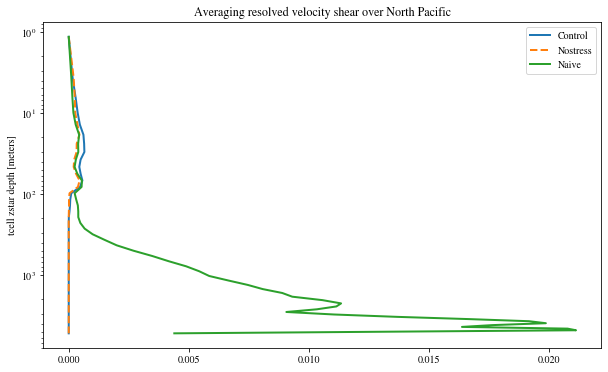

In [20]:
plt.figure(figsize = (10,6))

plt.yscale('log')
plt.gca().invert_yaxis()

Vtsq_avg_con.plot(label = 'Control',y = 'st_ocean')
Vtsq_avg_buo.plot(label = 'Nostress',y = 'st_ocean', ls = '--')
Vtsq_avg_naive.plot(label = 'Naive',y = 'st_ocean')
plt.legend()
plt.title('Averaging unresolved velocity shear over North Pacific')

Therefore, over the depth of the mixing layer, the resolved velocity shear is almost the same for all three cases. This leaves us with two more options - the surface buoyancy flux and the resolved velocity shear. Let's have a look at the latter first.

## 2. Plotting dVsq (Resolved velocity shear)

In [7]:
dVsq_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'dVsq', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))
dVsq_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'dVsq', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))
dVsq_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'dVsq', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))

Text(0.5, 1.0, 'Rsesolved velocity shear profile for latitude = -40 and longitude = 40')

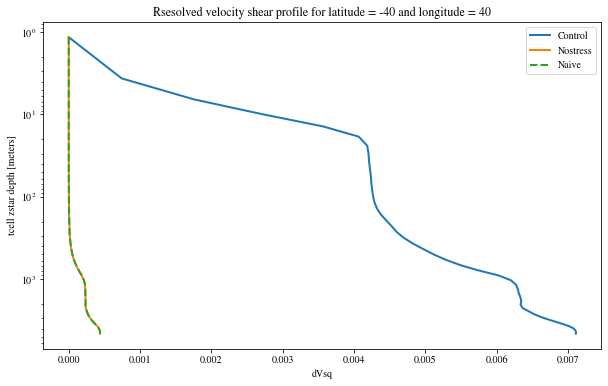

In [8]:
x_val = -40
y_val = 40
plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Control',y = 'st_ocean')
dVsq_buo.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Nostress',y = 'st_ocean')
dVsq_naive.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Naive',y = 'st_ocean',linestyle = '--')
plt.legend()
plt.title('Rsesolved velocity shear profile for latitude = ' + str(x_val) + ' and longitude = ' + str(y_val))

Text(0.5, 1.0, 'Rsesolved velocity shear profile for latitude = -180 and longitude = -30')

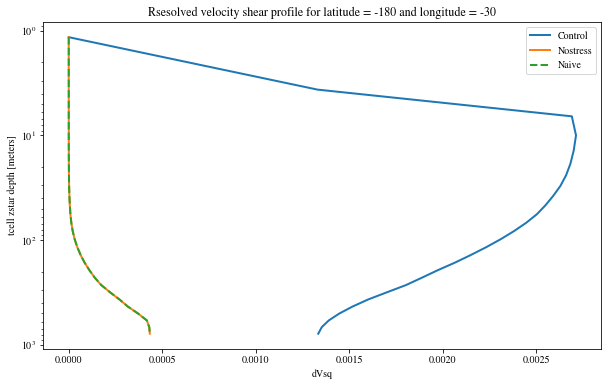

In [23]:
x_val = -180
y_val = -30
plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Control',y = 'st_ocean')
dVsq_buo.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Nostress',y = 'st_ocean')
dVsq_naive.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').mean('time').plot(label = 'Naive',y = 'st_ocean',linestyle = '--')
plt.legend()
plt.title('Rsesolved velocity shear profile for latitude = ' + str(x_val) + ' and longitude = ' + str(y_val))

Unlike the unresolved velocity shear, here, we see HUGE differences between the control and the no-stress/naive no-stress runs. This happens because in the MoM5 code, we take the u-velocity to find resolved velocity shear. This u-velocity is found out from the momentum equations, and for the no-stress/naive no-stress runs, they don't contain any effects of the wind stress. This creates an issue because the Richardson number is calculated differently, and this is why our KPP mixing layer shoals significantly, as the Richardson number reaches its critical values (0.25-0.3) at much shallower depths. 

Finally, we look at the surface buoyancy flux too, in case these plots diverge too.

## 3. Plotting bfsfc (Surface buoyancy flux)

In [4]:
bfsfc_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'bfsfc', frequency = '1 hourly')
bfsfc_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'bfsfc', frequency = '1 hourly')
bfsfc_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'bfsfc', frequency = '1 hourly')

Text(0.5, 1.0, 'Surface buoyancy flux profile for latitude = -80 and longitude = 20')

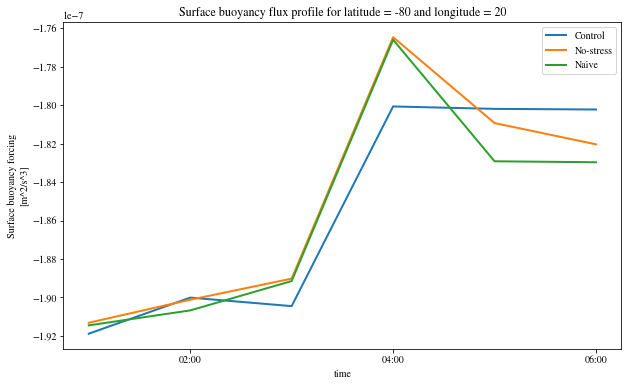

In [5]:
x_val = -80
y_val = 20
plt.figure(figsize = (10,6))
bfsfc_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').plot(label = 'Control')
bfsfc_buo.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').plot(label = 'No-stress')
bfsfc_naive.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').plot(label = 'Naive')
plt.legend()

plt.title('Surface buoyancy flux profile for latitude = ' + str(x_val) + ' and longitude = ' + str(y_val))

In [22]:
x_val = -60
y_val = 60

bfsfc_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').values

array(-2.5868255e-07, dtype=float32)

Text(0.5, 1.0, 'Surface buoyancy flux profile for latitude = -180 and longitude = 20')

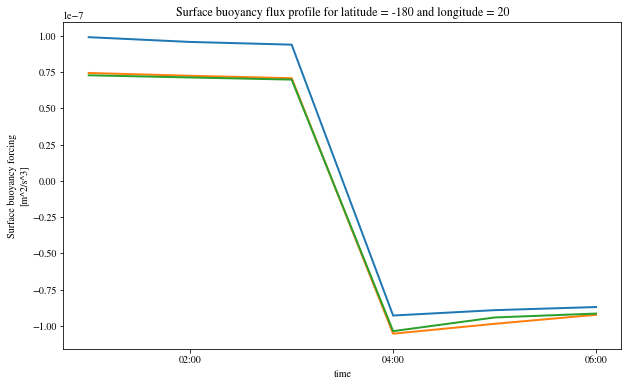

In [28]:
x_val = -180
y_val = 20
plt.figure(figsize = (10,6))
bfsfc_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').plot(label = 'Control')
bfsfc_buo.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').plot(label = 'No-stress')
bfsfc_naive.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').plot(label = 'Naive')

plt.title('Surface buoyancy flux profile for latitude = ' + str(x_val) + ' and longitude = ' + str(y_val))

This doesn't change much either. We need to build a new resolved velocity shear in the no-stress/naive no-stress runs, so that the Bulk Richardson number stays almost the same as in the control run. We find that there are three parameter to look out for:

(i) Friction velocity - This is directly related to the wind shear

(ii) Coriolis frequency - The latitude-dependence of resolved velocity shear is modelled through this term.

(iii) Depth - The resolved velocity shear is calculated for each depth, so variations in depth needs to be understood.

# Approximating resolved velocity shear

In [29]:
import pandas as pd

## 1. Correlation between dVsq and ustar

In [10]:
rho0 = 1025

tau_x_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'tau_x', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))
tau_y_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'tau_y', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))

ustar_con = (((tau_x_con**2 + tau_y_con**2)*(0.5))/rho0)**0.5

In [11]:
y_val = -50
z_val = 30

data1 = {'dVsq': dVsq_con.mean('time').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').values,
         'ustar': ustar_con.mean('time').sel(yu_ocean = y_val, method = 'nearest').values
        }

dVsq_ustar_df = pd.DataFrame(data = data1)
dVsq_ustar_df.corr()

NameError: name 'pd' is not defined

In [43]:
y_val = -50
z_val = 30

data1 = {'dVsq': dVsq_con.mean('time').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').values,
         'ustar_sq': (ustar_con.mean('time').sel(yu_ocean = y_val, method = 'nearest').values)**2
        }

dVsq_ustar_df = pd.DataFrame(data = data1)
dVsq_ustar_df.corr()

,dVsq,ustar_sq
dVsq,1.00000,0.91884
ustar_sq,0.91884,1.00000


## 2. Correlation between dVsq and f

In [15]:
omega = 7.2921 * 1e-5
f = 2*omega*np.sin(np.deg2rad(ustar_con.yu_ocean))

In [65]:
x_val = -120
z_val = 40

#x_val = -30
#y_val = 40

data2 = {'dVsq': dVsq_con.mean('time').sel(xu_ocean = x_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').values,
         'f': f
        }

dVsq_cf_df = pd.DataFrame(data = data2)

dVsq_cf_df.corr()

,dVsq,f
dVsq,1.000000,-0.409206
f,-0.409206,1.000000


In [59]:
x_val = -120
z_val = 40

data2 = {'dVsq': dVsq_con.mean('time').sel(xu_ocean = x_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').values,
         'f': np.exp(f**2)
        }

dVsq_cf_df = pd.DataFrame(data = data2)

dVsq_cf_df.corr()

,dVsq,f
dVsq,1.000000,0.428364
f,0.428364,1.000000


## 3. Correlation between dVsq and st_ocean

In [13]:
hblt_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'hblt', frequency = '1 hourly').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00'))

In [67]:
x_val = -30
y_val = 10

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
dVsq_trunc = dVsq_con.mean('time').sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val))
data3 = {'dVsq': dVsq_trunc.values,
         'exp(z)': np.exp(dVsq_trunc.st_ocean**0.5)
        }

dVsq_stocean_df = pd.DataFrame(data = data3)

dVsq_stocean_df.corr()

,dVsq,exp(z)
dVsq,1.000000,0.929568
exp(z),0.929568,1.000000


# Getting data for non-linear regression

## 1. $\frac{\partial u}{\partial z} \propto g_1(u_{*})$

## Data 1

In [94]:
y_val = 40
z_val = 10
df = dVsq_con.sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

In [95]:
df['ustar'] = ustar_con.sel(yu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

In [96]:
df.to_csv('Vel_shear/40lat_10depth.csv')

## Data 2

In [98]:
y_val = -30
z_val = 15
df = dVsq_con.sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

df['ustar'] = ustar_con.sel(yu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

df.to_csv('Vel_shear/30Slat_15depth.csv')

## Data 3

In [102]:
y_val = -40
z_val = 10
df = dVsq_con.sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

df['ustar'] = ustar_con.sel(yu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

df.to_csv('Vel_shear/40Slat_10depth.csv')

## Data 4

In [101]:
y_val = 30
z_val = 15
df = dVsq_con.sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

df['ustar'] = ustar_con.sel(yu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

df.to_csv('Vel_shear/30lat_15depth.csv')

# Data 5

In [100]:
y_val = 60
z_val = 20
df = dVsq_con.sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

df['ustar'] = ustar_con.sel(yu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

df.to_csv('Vel_shear/60lat_20depth.csv')

## Data 6

In [99]:
y_val = -60
z_val = 20
df = dVsq_con.sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

df['ustar'] = ustar_con.sel(yu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

df.to_csv('Vel_shear/60Slat_20depth.csv')

## 2. $\frac{\partial u}{\partial z} \propto g_2(f) $

## Data 1

In [111]:
x_val = 40
z_val = 10
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

In [112]:
df['f'] = f.values
df['ustar'] = ustar_con.sel(xu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

In [113]:
df.to_csv('Vel_shear/40Elon_10depth.csv')

## Data 2

In [114]:
x_val = -160
z_val = 10
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest').mean('time').to_pandas()#.to_csv('Test1.csv')
df = pd.DataFrame(df,columns = ['dVsq'])

df['f'] = f.values
df['ustar'] = ustar_con.sel(xu_ocean = y_val, method = 'nearest').mean('time')
df = df.dropna()

df.to_csv('Vel_shear/160Elon_10depth.csv')

## 3. $\frac{\partial u}{\partial z} \propto g_3(z) $

## Data 1

In [115]:
x_val = -30
y_val = 40

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val)).mean('time').to_pandas()
df = pd.DataFrame(df,columns = ['dVsq'])

df['z'] = dVsq_con.st_ocean.sel(st_ocean = slice(0,hblt_val))
df = df.dropna()

df.to_csv('Vel_shear/30Wlon40Nlat.csv')

## Data 2

In [116]:
x_val = -140
y_val = 40

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val)).mean('time').to_pandas()
df = pd.DataFrame(df,columns = ['dVsq'])

df['z'] = dVsq_con.st_ocean.sel(st_ocean = slice(0,hblt_val))
df = df.dropna()

df.to_csv('Vel_shear/140Wlon40Nlat.csv')

## Data 3

In [117]:
x_val = -140
y_val = -50

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val)).mean('time').to_pandas()
df = pd.DataFrame(df,columns = ['dVsq'])

df['z'] = dVsq_con.st_ocean.sel(st_ocean = slice(0,hblt_val))
df = df.dropna()

df.to_csv('Vel_shear/140Wlon50Slat.csv')

In [118]:
x_val = -20
y_val = -50

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val)).mean('time').to_pandas()
df = pd.DataFrame(df,columns = ['dVsq'])

df['z'] = dVsq_con.st_ocean.sel(st_ocean = slice(0,hblt_val))
df = df.dropna()

df.to_csv('Vel_shear/20Wlon50Slat.csv')

In [119]:
x_val = -50
y_val = 50

ustar_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').values

array([0.01031715], dtype=float32)

## Data 4

In [120]:
x_val = -20
y_val = 50

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val)).mean('time').to_pandas()
df = pd.DataFrame(df,columns = ['dVsq'])

df['z'] = dVsq_con.st_ocean.sel(st_ocean = slice(0,hblt_val))
df = df.dropna()

df.to_csv('Vel_shear/20Wlon50Nlat.csv')

## Data 6

In [121]:
x_val = -50
y_val = 50

hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
df = dVsq_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(st_ocean = slice(0,hblt_val)).mean('time').to_pandas()
df = pd.DataFrame(df,columns = ['dVsq'])

df['z'] = dVsq_con.st_ocean.sel(st_ocean = slice(0,hblt_val))
df = df.dropna()

df.to_csv('Vel_shear/50Wlon50Nlat.csv')

In [17]:
import pandas as pd

# Correlation between dVsq and the three terms

In [25]:
x_val = -100
z_val = 5

ustar_val = ustar_con.mean('time').sel(xu_ocean = x_val, method = 'nearest').values
hblt_val = hblt_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values[0]
dVsq_trunc = dVsq_con.mean('time').sel(xu_ocean = x_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest')
dVsq_buo_trunc = dVsq_buo.mean('time').sel(xu_ocean = x_val, method = 'nearest').sel(st_ocean = z_val, method = 'nearest')
data4 = {'dVsq': dVsq_trunc.values,
         'u and f': abs(f)**(-0.2) * (2*ustar_val**2 + ustar_val)
        }

dVsq_stocean_df = pd.DataFrame(data = data4)

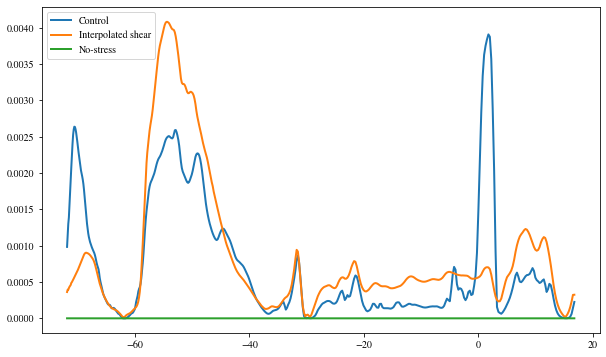

In [26]:
ustar_sub = ustar_con.mean('time').sel(xu_ocean = x_val, method = 'nearest').values

plt.figure(figsize = (10,6))
plt.plot(dVsq_con.yu_ocean, dVsq_trunc.values, label = 'Control')
plt.plot(dVsq_con.yu_ocean, 4*(0.5*ustar_sub) * (np.exp(-0.0065*z_val*np.abs(f)**3/ustar_sub**0.5)) * (z_val/20), label = 'Interpolated shear')
plt.plot(dVsq_buo.yu_ocean, dVsq_buo_trunc.values, label = 'No-stress')
plt.legend()

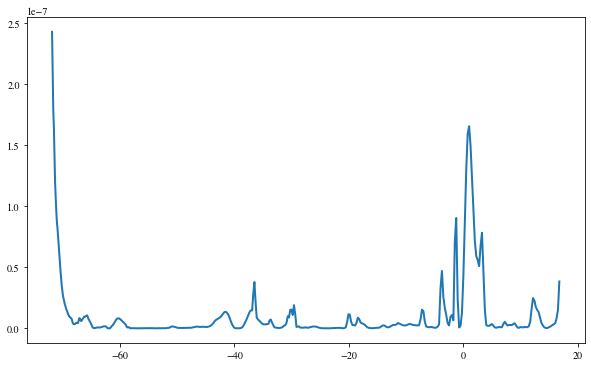

In [27]:
plt.figure(figsize = (10,6))
plt.plot(dVsq_buo.yu_ocean, dVsq_buo_trunc.values)